<a href="https://colab.research.google.com/github/Akramz/vllm-satim-labeling/blob/main/notebooks/starter_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Starter Code

In this notebook, we want to use an open source Vision-LLM to label satellite imagery in Africa. We will cover the following:

1. Install the required dependencies.
2. Download, extract, and load the dataset.
3. Load the (quantized) model.
4. Create a pipeline to label the images.
5. Export performance metrics on the training set.
6. Export a sample submission file on the test set that we can submit to Kaggle.



## Installing Dependencies

In [ ]:
!pip install -q -U transformers==4.37.2
!pip install -q bitsandbytes==0.41.3 accelerate==0.25.0
!pip install -q datasets
!pip install -q evaluate
!pip install -q scikit-learn
!pip install -q gdown
!pip install -q seaborn

In [9]:
import re
import random
from pathlib import Path
import random
from datetime import *
from tqdm import tqdm

random.seed(1337)

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset

In [ ]:
import torch
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset
from transformers import BitsAndBytesConfig
from sklearn.metrics import confusion_matrix, f1_score

## Data Preparation


In [12]:
# Download and extract the dataset
!mkdir -p data/
!gdown -O data/dataset.zip "https://drive.google.com/uc?id=1jw8vz6KvBm5u0RZExTEB4Zk1zjklEvea"
!unzip data/dataset.zip -d data/

Downloading...
From (original): https://drive.google.com/uc?id=1jw8vz6KvBm5u0RZExTEB4Zk1zjklEvea
From (redirected): https://drive.google.com/uc?id=1jw8vz6KvBm5u0RZExTEB4Zk1zjklEvea&confirm=t&uuid=1735238f-68f6-4dca-8887-1c8ff10816fe
To: /Users/akramzaytar/projects/Career/DLI/workshop_competition/vllm_satim_labeling/notebooks/data/dataset.zip
100%|████████████████████████████████████████| 109M/109M [00:24<00:00, 4.37MB/s]
Archive:  data/dataset.zip
   creating: data/dataset/
   creating: data/dataset/test/
  inflating: data/dataset/test/10480.png  
  inflating: data/dataset/test/10685.png  
  inflating: data/dataset/test/10689.png  
  inflating: data/dataset/test/107712.png  
  inflating: data/dataset/test/109039.png  
  inflating: data/dataset/test/109550.png  
  inflating: data/dataset/test/10989.png  
  inflating: data/dataset/test/11238.png  
  inflating: data/dataset/test/11252.png  
  inflating: data/dataset/test/11262.png  
  inflating: data/dataset/test/113069.png  
  inflating:

In [13]:
# Visualize some training patches
root = Path("./data/dataset/train")
assert root.exists()

In [14]:
# Load the training metadata file
train_md = pd.read_csv(root / "metadata.csv")
train_md.head()

,file_name,timestamp,lat,lon,label
0,81521.png,2015-12-07T07:55:12Z,-6.828652,39.226942,single-unit_residential
1,306318.png,2017-01-21T11:37:17Z,8.476594,-13.183149,storage_tank
2,422373.png,2016-01-13T09:55:32Z,9.082343,7.486646,place_of_worship
3,433952.png,2016-08-11T08:39:18Z,-32.977957,27.898485,ground_transportation_station
4,474820.png,2017-02-24T07:22:52Z,2.073873,45.323374,place_of_worship


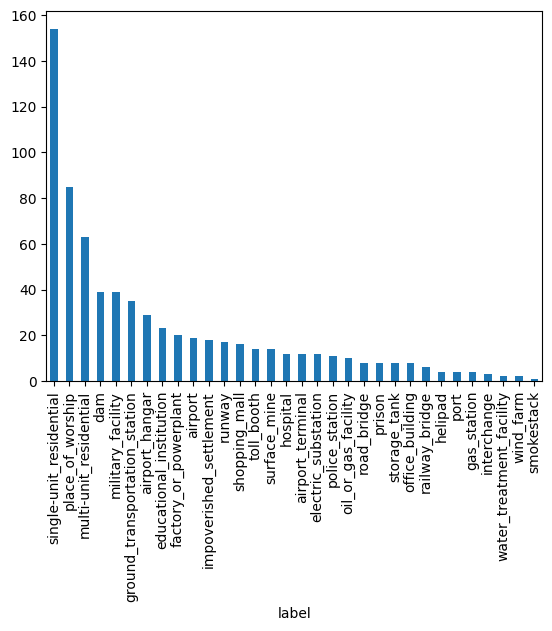

In [15]:
# Check the label distribution
_ = train_md["label"].value_counts().plot(kind="bar")

We plot a few examples by label:

In [16]:
def plot(d, label, n=10):
    imgs = d.loc[d["label"] == label, "file_name"]
    n_ = n if n < len(imgs) else len(imgs)
    imgs = imgs.sample(n_).tolist()
    fig, axes = plt.subplots(1, n_, figsize=(20, 5))
    for i, ax in enumerate(axes):
        ax.imshow(plt.imread(root / imgs[i]))
        ax.axis("off")
        ax.set_title(imgs[i])
    plt.show()

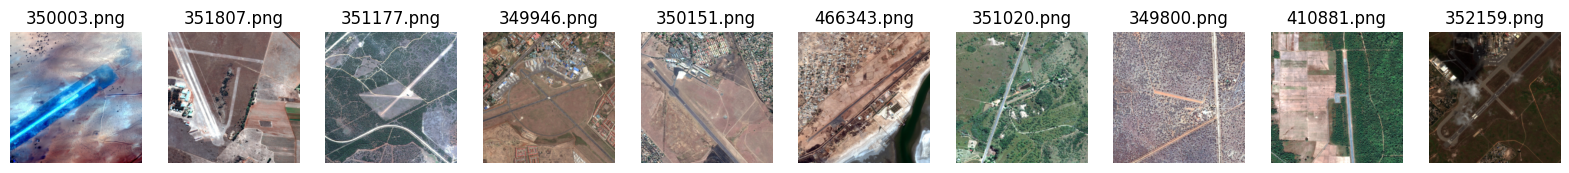

In [17]:
plot(train_md, "runway")

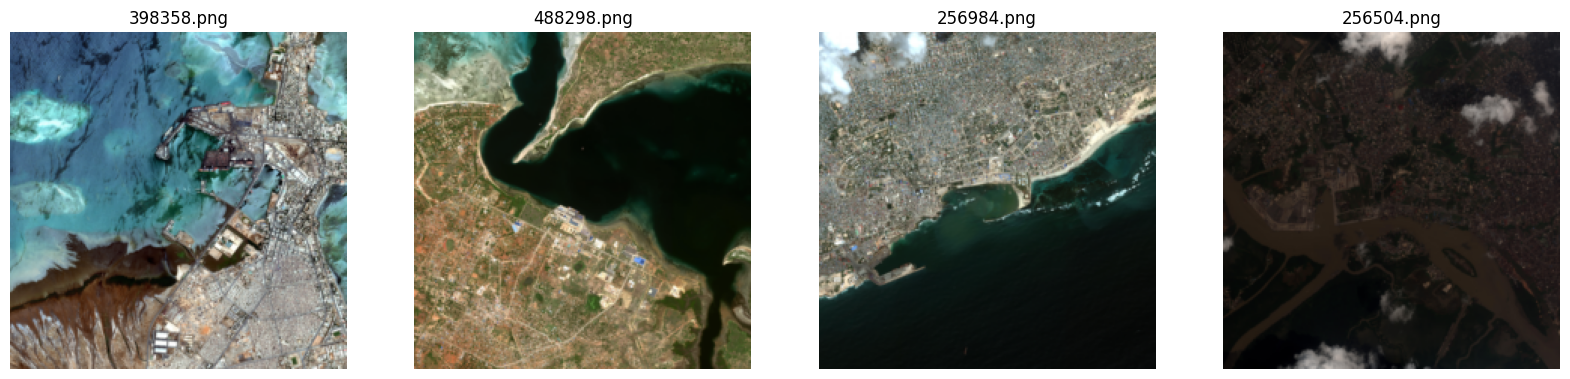

In [18]:
plot(train_md, "port")

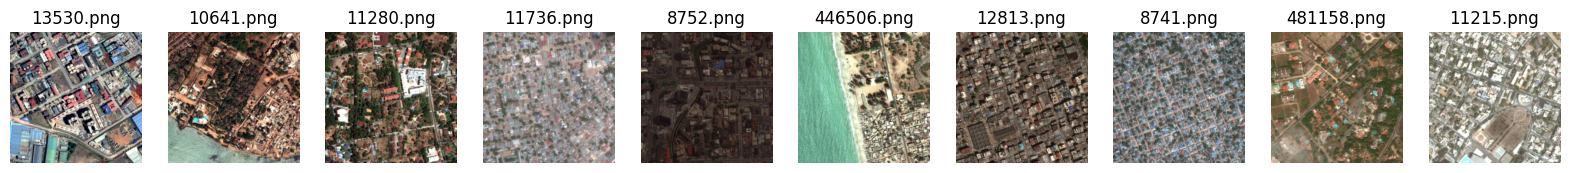

In [19]:
plot(train_md, "multi-unit_residential")

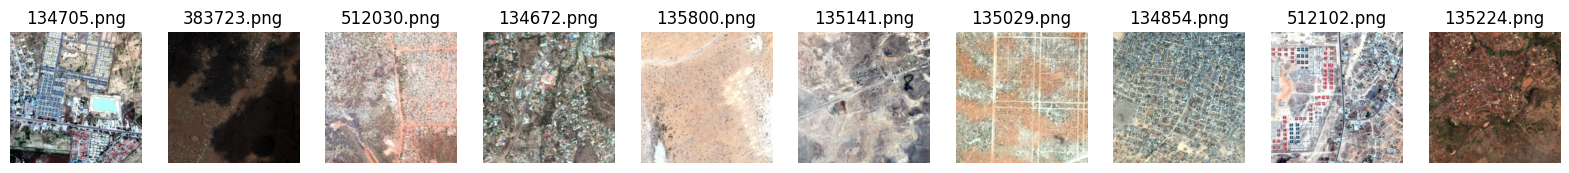

In [20]:
plot(train_md, "impoverished_settlement")

Let's load the dataset now:

In [ ]:
# Add a placeholder `label` for the `test` dataset
test_md = pd.read_csv("./data/dataset/test/metadata.csv")
test_md["label"] = "o"
test_md.to_csv("./data/dataset/test/metadata.csv", index=False)

In [ ]:
data_path = "africa_dataset"
train_ = load_dataset("imagefolder", data_path, split="train")

## Model Loading

In [ ]:
# Set quantization
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16
)

# Set the model name
model_id = "llava-hf/llava-1.5-7b-hf"

# Create pipeline
pipe = pipeline(
    "image-to-text",
    model=model_id,
    trust_remote_code=True,
    model_kwargs={"quantization_config": quantization_config},
)

## Prompting

We create a map from indices to labels.

*Note: You may use custom indexes to represent the label strings **BUT remember** to provide the **label strings** in the submission file.*

In [ ]:
idx_to_label_map = {
    0: "single-unit residential",
    1: "storage tank",
    2: "place of worship",
    3: "ground transportation station",
    4: "airport hangar",
    5: "toll booth",
    6: "dam",
    7: "educational institution",
    8: "surface mine",
    9: "road bridge",
    10: "hospital",
    11: "prison",
    12: "electric substation",
    13: "military facility",
    14: "multi-unit residential",
    15: "airport",
    16: "oil or gas facility",
    17: "helipad",
    18: "police station",
    19: "runway",
    20: "railway bridge",
    21: "impoverished settlement",
    22: "shopping mall",
    23: "port",
    24: "water treatment facility",
    25: "factory or powerplant",
    26: "interchange",
    27: "airport terminal",
    28: "smokestack",
    29: "office building",
    30: "gas station",
    31: "wind farm",
}

In [ ]:
# Set the maximum number of model output tokens
max_new_tokens = 10

prompt = f"""
USER: <image>
Given the following classes: {str(idx_to_label_map)}.\nYour task is to analyze the image, identify the primary category that best matches the image content, and return only the class key as an int.\nASSISTANT: Class key:"""

Next, we define a post-processing to get the first mentioned object type:

In [ ]:
def process_result(input_string):
    print(input_string)
    match = re.search(r"ASSISTANT:.*?(\d+)", input_string)
    if match:
        return int(match.group(1))
    return -1

Let's sample a bunch of data point sto run inference & evaluation on:

In [ ]:
# Sample 64 elements from the dataset
sample_size = 64
X = train_.select(random.sample(range(len(train_)), sample_size))

We can use our Vision-LLM to predict the categories:

In [ ]:
outputs = list()

prepped_dataset = KeyDataset(X, "image")
for out in tqdm(
    pipe(
        prepped_dataset,
        prompt=prompt,
        generate_kwargs={"max_new_tokens": max_new_tokens},
    ),
    total=len(prepped_dataset),
):
    outputs.append(process_result(out[0]["generated_text"]))

X = X.add_column("y_hat", outputs)

Let's map predicted indices back to original labels

In [ ]:
X = X.map(lambda x: {"y_hat": idx_to_label_map.get(x["y_hat"], "unk")})

## Evaluation

We calculate the confusion matrix and visualize accuracy per class

In [ ]:
# Get the targets and predictions
targets = X["label"]
predictions = X["y_hat"]

# Visualize the confusion matrix
cm = confusion_matrix(targets, predictions)
class_acc = cm.diagonal() / cm.sum(axis=1)
macro_acc = class_acc.mean()


fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", ax=ax)
fig.suptitle("Confusion Matrix\n Macro Accuracy: {:.2f}".format(macro_acc))
plt.show()

We calculate macro f1. This is the evaluation metric for this competition.

In [ ]:
f1 = f1_score(targets, predictions, average="macro")
f1

## Generating a sample submission file

In [ ]:
# Random baseline submission file
test = pd.read_csv("./data/dataset/test/metadata.csv")

# Select the columns
cols = ["file_name", "label"]
test = test[cols].rename(columns={"file_name": "ID"})

# Assign random labels from 0 to 21 to `label`
test["label"] = np.random.randint(0, 22, size=len(test))

# Save the submission file
test.to_csv("random_baseline_submission.csv", index=False)

---